In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
import utils

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [4]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [5]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Visual analysis

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def compile_obj(t, flux, flux_err, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = flux_err
    obj['passband'] = passband
    return obj

In [12]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

In [13]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)
    
def plot_loghist(x, bins, **kwargs):
    """
    https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
    """
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, **kwargs)
    plt.xscale('log')
    
def plot_metrics_histogram(report, **hist_kwargs):
    plt.figure(figsize=(20, 20))
    for idx, metric in enumerate(report.columns[1:], 1):
        plt.subplot(3, 2, idx)
        plot_loghist(report[metric], bins=50)
        plt.xlabel(metric, size=14)
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.xscale('log')
        plt.grid()
    plt.show()

34299


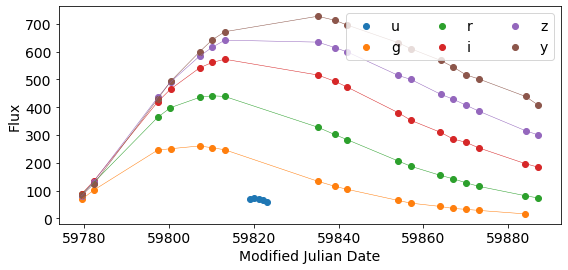

43812


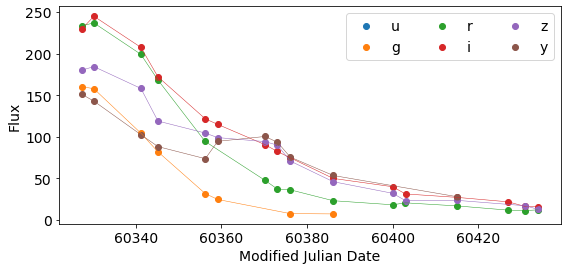

70046


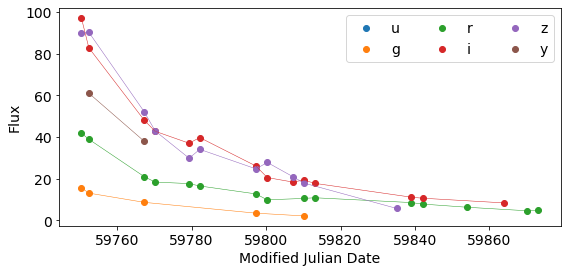

84716


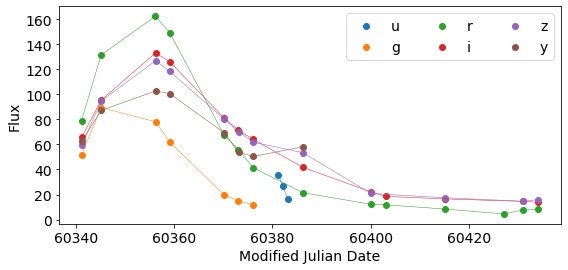

131629


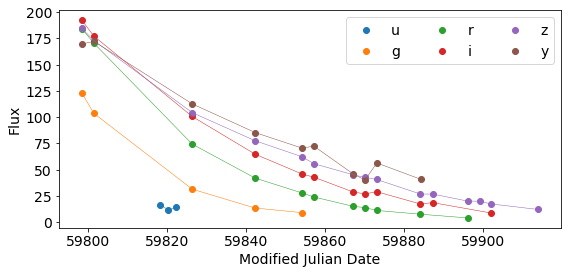

169315


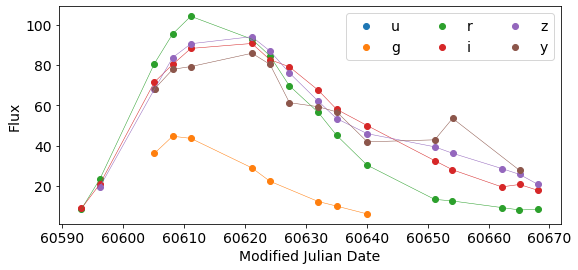

229855


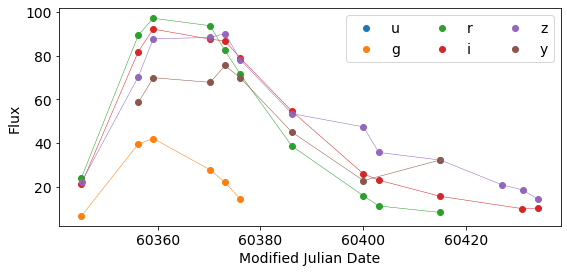

251430


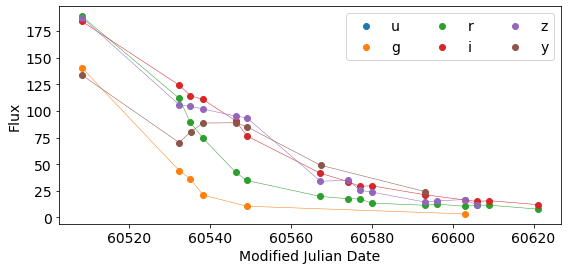

282714


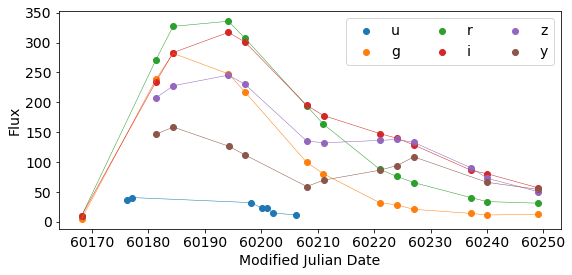

290682


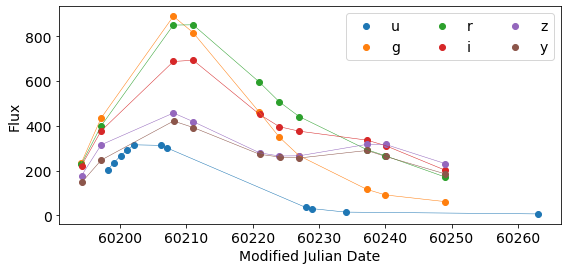

316306


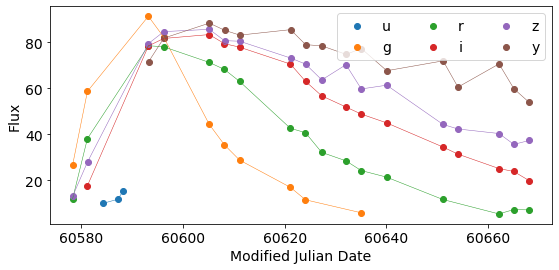

In [14]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()

# One object test Test

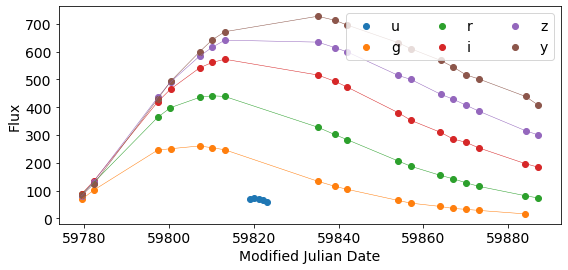

In [15]:
anobject = get_object(data, 34299)

plot_light_curves(anobject)

In [16]:
# train / test split
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

In [17]:
import rbfnet_aug

# fit augmentation model
model = rbfnet_aug.RBFNetAugmentation(passband2lam, n_hidden=300, lam=0., n_epochs=300, lr=0.01, batch_size=100)
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                 anobject['mjd'].max(), n_obs=1000)

In [18]:
anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, 
                                 flux_err_pred, anobject_test['passband'].values)
anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)

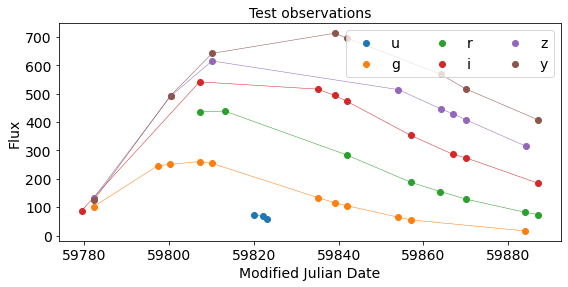

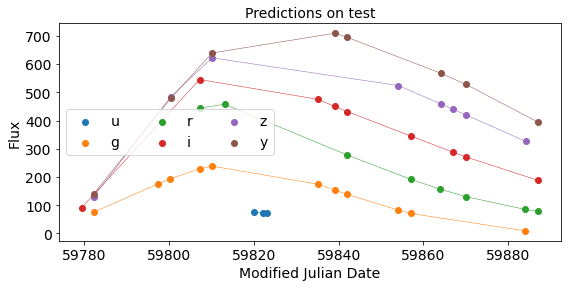

In [19]:
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

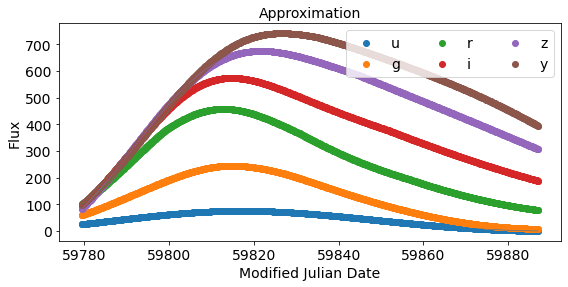

In [20]:
plot_light_curves(anobject_aug, "Approximation")

In [21]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  22.064387969022395
MAE:  15.225025100641775
RSE:  0.11136891782135801
RAE:  0.08694357381988432
MAPE:  9.187209680269493


# Test on many objects

In [22]:
report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in object_ids:
    
    # get an object
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    
    print("Object ", i, " with ", len(anobject), " observations")
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)    
    
    # fit augmentation model
    model = rbfnet_aug.RBFNetAugmentation(passband2lam, n_hidden=300, lam=0., n_epochs=300, lr=0.01, batch_size=100)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)
    
    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)
    anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, 
                                     flux_err_pred, anobject_test['passband'].values)
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                      anobject_test_pred['flux'].values)
    print(metrics)
    report.loc[len(report), :] = [i] + list(metrics)

Object  745  with  61  observations
[5.267013774897093, 3.153965850570188, 0.10061791788957884, 0.08529516892958801, 9.417881992725317]
Object  1124  with  61  observations
[5.412985373063892, 3.4881645629242928, 0.14557825757969944, 0.13031919965716307, 13.893132380553654]
Object  1920  with  55  observations
[14.371399623924155, 9.071497740471978, 0.23234305783933767, 0.1814717373066576, 24.65365144693359]
Object  2922  with  58  observations
[15.051567320996712, 7.068914272328342, 0.217519329970185, 0.20082933444867745, 16.05745594714219]
Object  4173  with  77  observations
[3.2997544705977173, 2.3130187326738394, 0.06654962417011989, 0.056364181411082306, 5.220801491817737]
Object  4389  with  58  observations
[3.5940629222384315, 2.7697952350169213, 0.13268977514205343, 0.1276349779270576, 15.651256145875392]
Object  4819  with  73  observations
[27.29415711180425, 13.388489287397228, 0.45718941647164624, 0.330059100241092, 25.702797411157917]
Object  6180  with  55  observations

[21.135781142795885, 13.420881321115802, 0.3442788037894679, 0.24725354443555825, 20.562514464365655]
Object  44217  with  78  observations
[6.7400346510203315, 4.821041331761288, 0.17514115814980408, 0.1484719793200941, 17.286813106414048]
Object  44309  with  85  observations
[19.779288480138067, 9.00934580697916, 0.3680947858383864, 0.21156267573308535, 13.079002060774458]
Object  45060  with  79  observations
[4.161496370181942, 2.883013285505677, 0.07524473537268547, 0.06270556122351476, 6.417657531842109]
Object  48187  with  73  observations
[8.12918830500687, 4.9859603700058415, 0.26429113921829883, 0.18505267245088117, 13.128176440441495]
Object  48473  with  99  observations
[64.76157446029964, 38.28655795577149, 0.36372735027802844, 0.26332694700451775, 20.230076888634027]
Object  49529  with  88  observations
[3.4100296059252946, 2.717544025532113, 0.03749453064575074, 0.0337412475786216, 2.605665528710609]
Object  49937  with  69  observations
[44.72389296537837, 20.251459

[15.012464744771455, 6.133190690356914, 0.30431730643368204, 0.16020867545410875, 13.740836231057514]
Object  93509  with  46  observations
[2.421297370576603, 1.7201979959106446, 0.6829681645492981, 0.6410939298493558, 14.693365520969259]
Object  94004  with  67  observations
[5.368521088509706, 3.765863506302329, 0.3673941641462624, 0.30932776339004164, 17.85125769723465]
Object  94229  with  66  observations
[10.214238324358663, 6.60663893467065, 0.18611253915439216, 0.14140029082261693, 12.472020476976283]
Object  95566  with  48  observations
[8.53333773956549, 5.481378960193633, 0.21106453565039351, 0.1626395197043619, 19.460547680066245]
Object  97406  with  57  observations
[2.7620551907810604, 2.2168988877121487, 0.13797228942483247, 0.14396423875075398, 9.993064896036401]
Object  97687  with  52  observations
[4.406006058301248, 3.236306784687923, 0.17496203560188742, 0.14248415716807944, 12.103608464726829]
Object  97850  with  77  observations
[13.156481250728406, 7.1541746

[12.947444091488197, 9.37540213568929, 0.21889028349667172, 0.19550402776503742, 40.40704566963247]
Object  128967  with  46  observations
[6.076343076993958, 4.282453547284998, 0.22783193771986687, 0.20173184886747295, 15.526037482496797]
Object  129179  with  82  observations
[8.989716136415252, 5.511158985117843, 0.22729161811159806, 0.1773712042443249, 17.230410252787326]
Object  129648  with  53  observations
[6.560508956513603, 4.601069188416658, 0.14378972011318578, 0.1262527981329302, 10.432544233056015]
Object  130220  with  46  observations
[5.766328580025097, 4.710137528094747, 0.25491737978657353, 0.23787417428638008, 19.823320181497287]
Object  130404  with  65  observations
[6.155674569358694, 4.1911606728978, 0.3732976781232187, 0.30338228804454886, 14.22525163611215]
Object  130502  with  61  observations
[8.55986411392959, 5.425943133796936, 0.07161903898513061, 0.060428737093226034, 23.865299639456634]
Object  130750  with  67  observations
[27.301547438713857, 21.673

[11.923356907216949, 6.900427569727971, 0.49700701937763253, 0.3919680341301519, 34.19941877632882]
Object  173059  with  61  observations
[8.000600206128325, 6.664794444331999, 0.1267481231938892, 0.12960070342438007, 14.55303106193175]
Object  174258  with  67  observations
[24.52049501319691, 13.089031249937172, 0.2116470933859876, 0.14923751050489964, 17.853983702714093]
Object  174968  with  71  observations
[30.334626376307238, 13.434240628531137, 0.5979728244729902, 0.31441393730984174, 19.817539069856544]
Object  175185  with  76  observations
[14.414868317519021, 8.229338613811697, 0.22328761242270573, 0.15595510430413848, 14.36636925303589]
Object  175409  with  56  observations
[2.987270126818171, 2.3698811937898903, 0.3043392967951079, 0.3184918586614467, 16.085564505425392]
Object  175477  with  86  observations
[3.2268775125899634, 2.023276105589401, 0.11959155717760735, 0.11256478780672872, 7.518728247904349]
Object  175935  with  49  observations
[8.090166312778905, 4.8

[8.854325830171135, 5.578216087158202, 0.318523053423917, 0.23141666558859225, 21.380151989239458]
Object  206547  with  85  observations
[10.59090600975227, 4.374010145294189, 0.23818494920264696, 0.14152990420945585, 10.701858581666325]
Object  207413  with  52  observations
[60.44120364666368, 37.394784868581915, 0.5648669753416209, 0.4519102465714445, 21.342918697938302]
Object  207496  with  73  observations
[12.107179229353482, 7.285151819045606, 0.19009744986053478, 0.14356066231193582, 20.415714566881622]
Object  207535  with  51  observations
[12.185291115388592, 7.378352242767335, 0.19227182371297602, 0.15630148871723087, 16.048400344600015]
Object  207549  with  71  observations
[53.97002912327331, 28.531945509053553, 0.8442674525839723, 0.6134136943872982, 57.432513904151655]
Object  207745  with  70  observations
[47.67837359216559, 27.943885319358603, 0.4078955349440082, 0.3020159321740261, 53.218787084361644]
Object  208261  with  47  observations
[19.088714088654648, 12

[10.285921076075208, 7.148764640961328, 0.2077298825900967, 0.17049049024146648, 14.083444522085736]
Object  237146  with  42  observations
[7.210471547452151, 5.25034301280285, 0.29154456781379473, 0.23878560157285797, 14.042481992444731]
Object  237149  with  77  observations
[19.81316214280732, 11.515697101288627, 0.16966333855438218, 0.11835346813323427, 11.433972843090906]
Object  237164  with  63  observations
[53.456605355529575, 26.773993740119927, 0.31696608713571794, 0.18262023395922258, 88.40979959014135]
Object  238604  with  89  observations
[29.55165866744275, 13.023928413837355, 0.20327083443276303, 0.11272373187760591, 8.28788843018772]
Object  239080  with  58  observations
[17.474737796838042, 6.963322939823544, 0.5418701878673375, 0.31322576403646696, 14.710263968849672]
Object  239227  with  53  observations
[4.754573739977171, 3.9633677009254735, 0.07579073219011723, 0.07810017207179683, 8.630627945556704]
Object  240336  with  58  observations
[10.742356419108853,

[78.16036322796607, 54.465900947739556, 0.38804668917437013, 0.35041417378909584, 11.395558311004805]
Object  275128  with  81  observations
[6.411524684310402, 4.295136720351802, 0.09642632348733746, 0.07657827016239444, 15.479878282870496]
Object  275987  with  80  observations
[13.228394317973304, 10.45868752846985, 0.05965693599089103, 0.05566786487706354, 9.25594150857373]
Object  278670  with  74  observations
[2.093908388011622, 1.5115308404639995, 0.23704043504905412, 0.2033452396926787, 7.811065185876804]
Object  278959  with  47  observations
[12.316121364116592, 5.314197689047496, 0.3278959732472872, 0.1914240300644436, 10.034775949768719]
Object  279292  with  63  observations
[7.952546547907934, 5.520566254055025, 0.10567471494565812, 0.08843952536559878, 6.736164361914421]
Object  279402  with  70  observations
[35.74232074139955, 20.0893779886152, 0.642320469502533, 0.4177508238356759, 42.225073050439704]
Object  280917  with  54  observations
[10.988310017599764, 6.4348

[8.148735114729607, 5.122978910664628, 0.2937267888211084, 0.2030258115653592, 18.226842514546505]
Object  316336  with  77  observations
[61.79768399439793, 34.113809045038124, 0.3475981287305387, 0.23455774527486425, 24.91958965518438]
Object  316773  with  95  observations
[31.237087673401174, 12.050345673922221, 0.3815342592880798, 0.22891674998806874, 14.62868181632836]
Object  317575  with  51  observations
[2.8505573464996123, 1.6017963817467316, 0.255625418994745, 0.18645118428850602, 14.929463052236157]
Object  318146  with  57  observations
[6.942997753977438, 5.587472332932045, 0.33284063868633595, 0.31137104599992366, 35.46110106628623]
Object  319554  with  79  observations
[22.865009223954683, 9.942619018010712, 0.3925001730193638, 0.2072192332544334, 31.368190430415233]
Object  319901  with  57  observations
[4.783868144975058, 3.548446022308349, 0.12209829134447236, 0.10967842999912136, 13.357868423003245]
Object  320200  with  58  observations
[4.961711929118455, 3.278

In [23]:
np.round(report.mean(), 2)

ID      340898.23
RMSE        27.05
MAE         15.47
RSE          0.26
RAE          0.20
MAPE        17.44
dtype: float64

In [24]:
report

,ID,RMSE,MAE,RSE,RAE,MAPE
0,745,5.26701,3.15397,0.100618,0.0852952,9.41788
1,1124,5.41299,3.48816,0.145578,0.130319,13.8931
2,1920,14.3714,9.0715,0.232343,0.181472,24.6537
3,2922,15.0516,7.06891,0.217519,0.200829,16.0575
4,4173,3.29975,2.31302,0.0665496,0.0563642,5.2208
...,...,...,...,...,...,...
511,339169,3.6812,2.45501,0.247385,0.190019,9.55744
512,341653,9.92701,6.89546,0.33288,0.27239,19.4316
513,342659,7.45622,4.62455,0.21943,0.166112,17.2881
514,8366012,23.6555,19.4573,0.193954,0.176691,25.4397


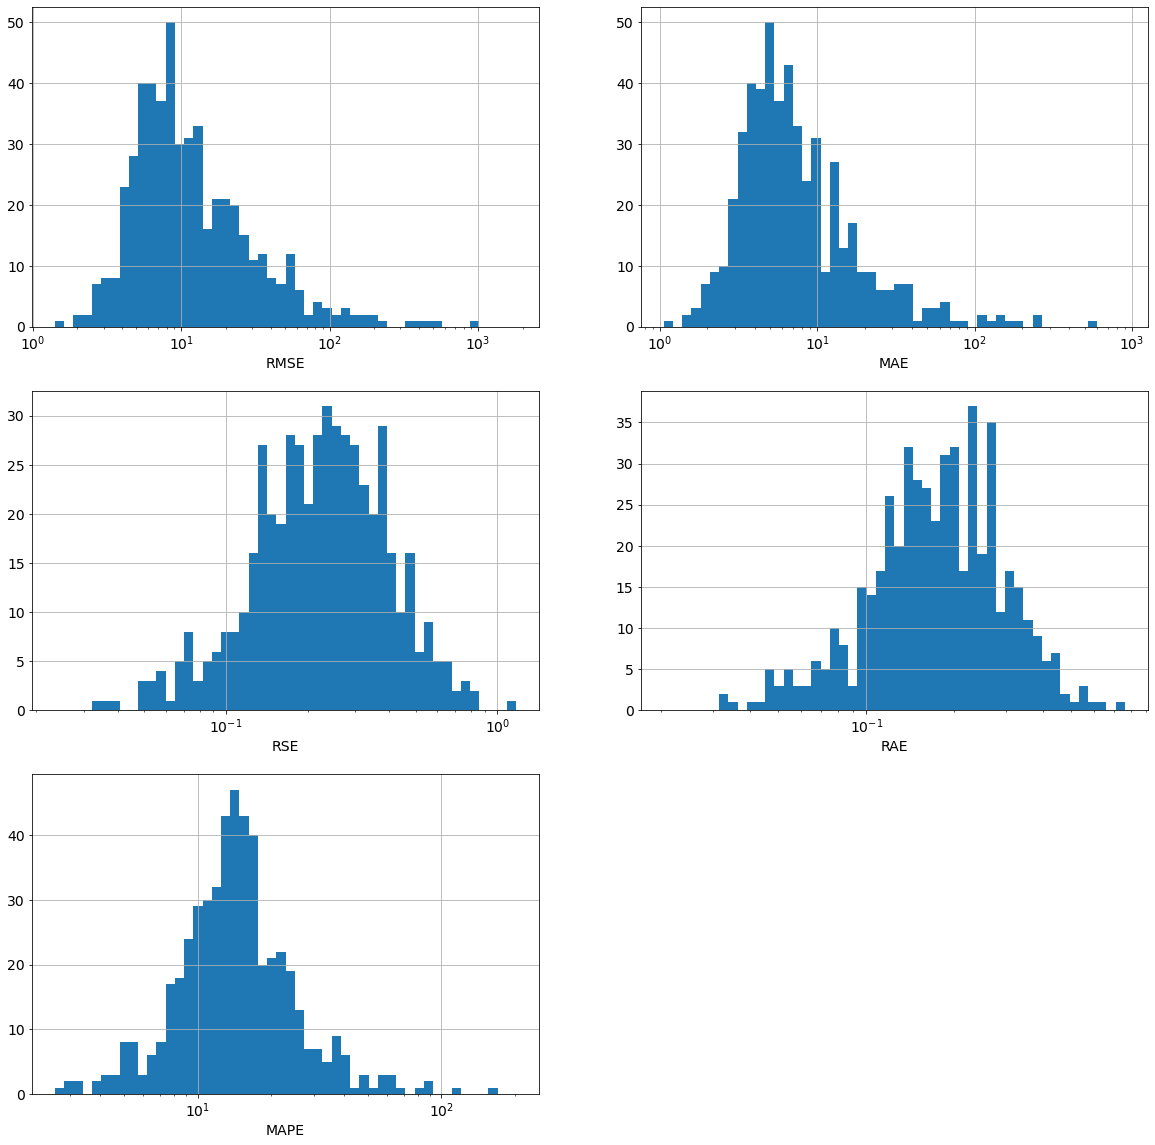

In [25]:
plot_metrics_histogram(report)

34299


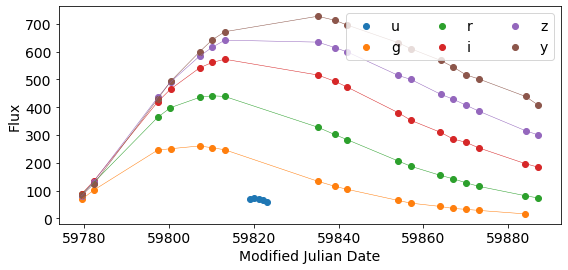

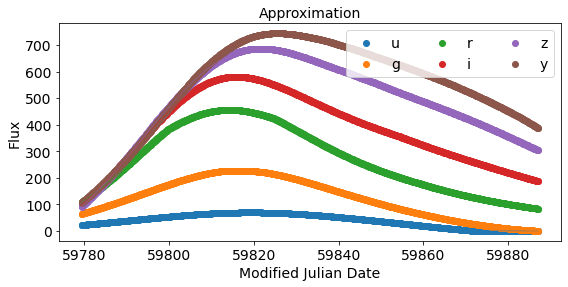

43812


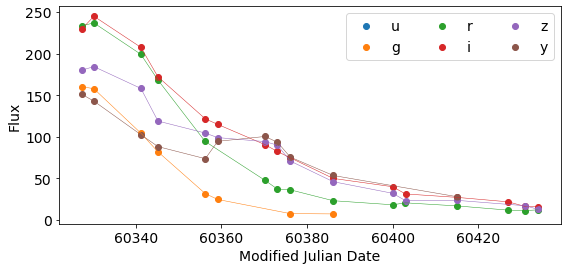

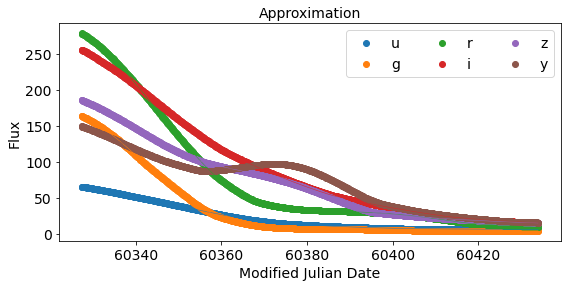

70046


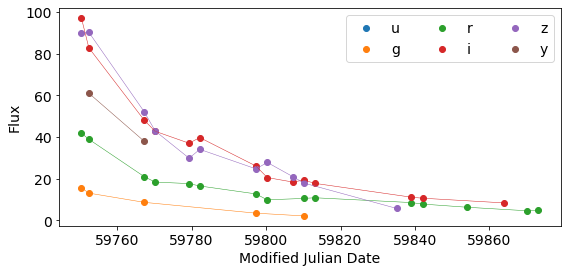

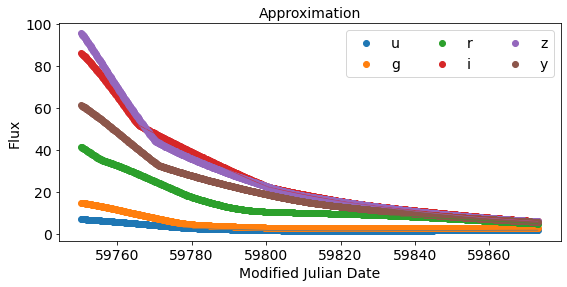

84716


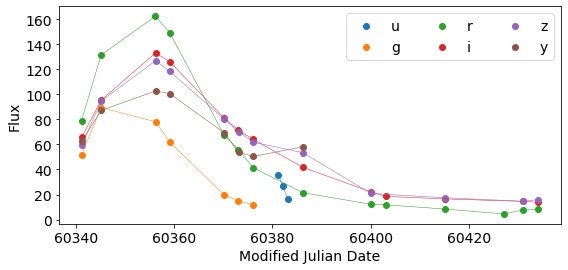

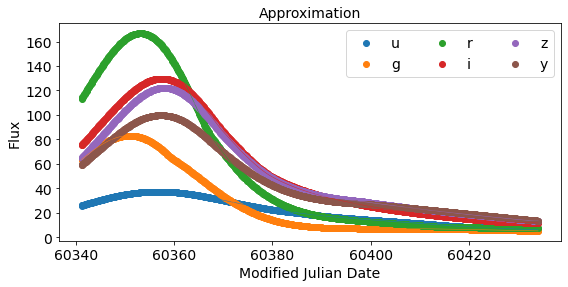

131629


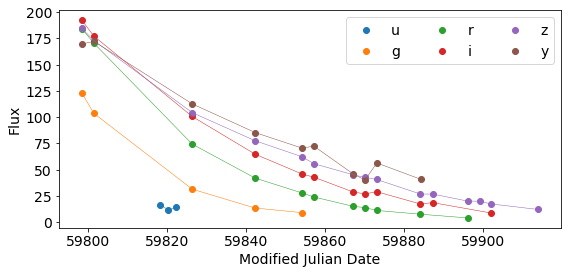

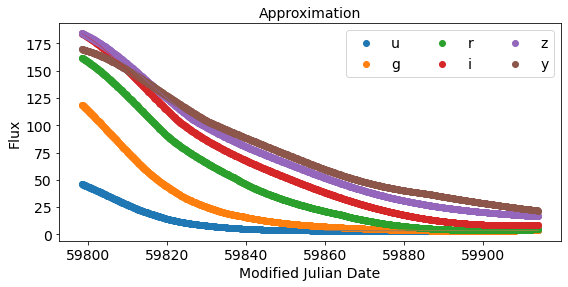

169315


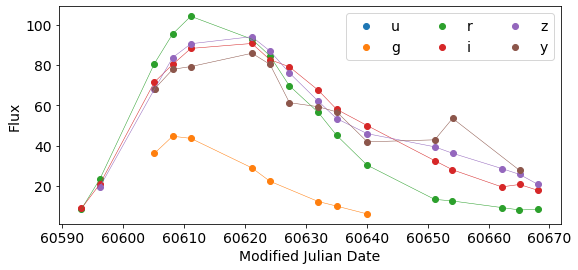

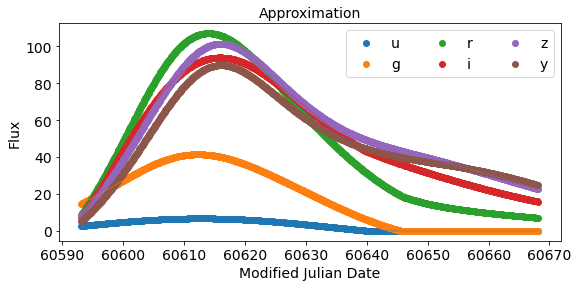

229855


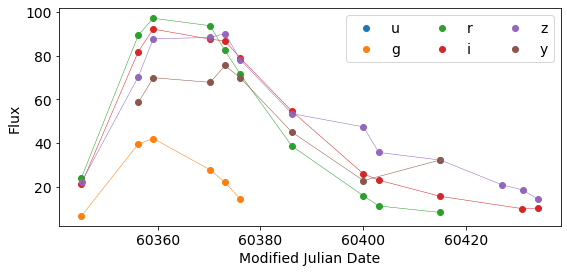

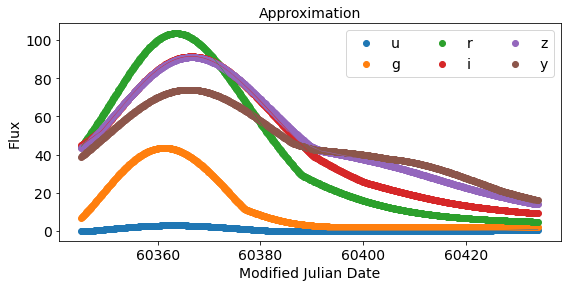

251430


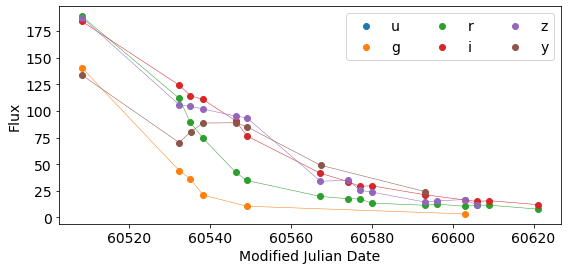

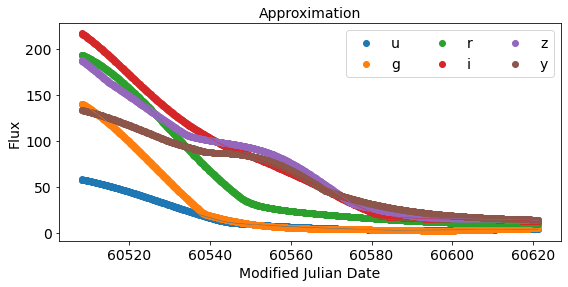

282714


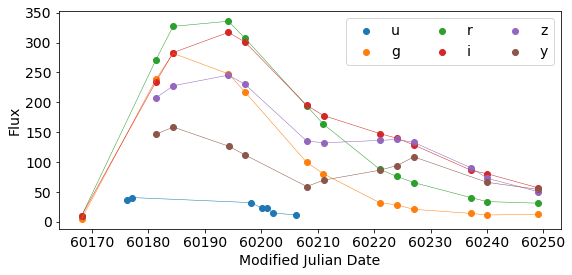

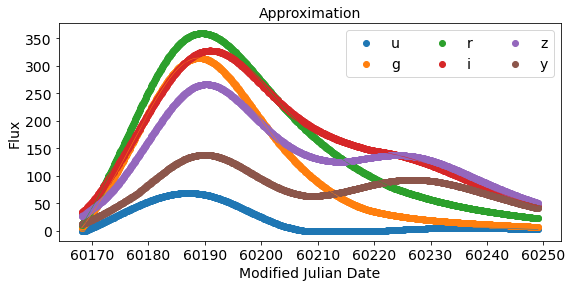

290682


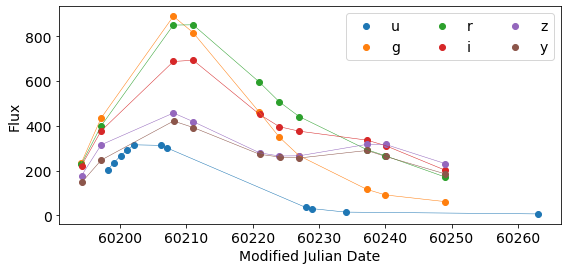

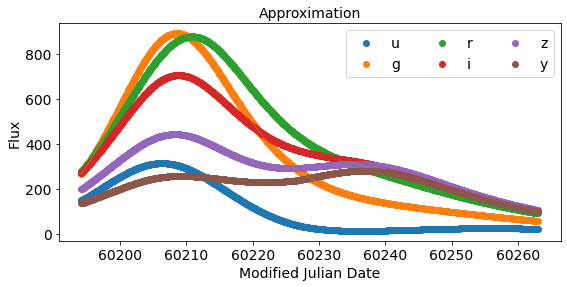

316306


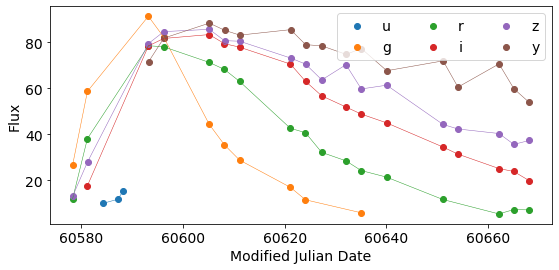

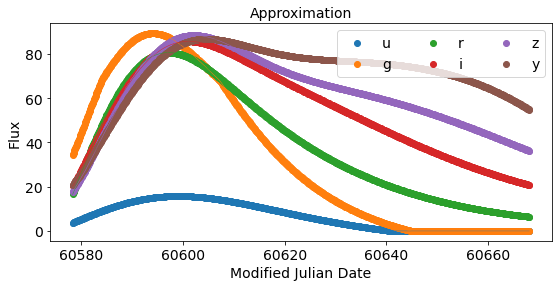

In [26]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()
    
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    model = rbfnet_aug.RBFNetAugmentation(passband2lam, n_hidden=200, lam=0., n_epochs=300, lr=0.01, batch_size=100)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                     anobject['mjd'].max(), n_obs=1000)
    anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)
    plot_light_curves(anobject_aug, "Approximation")
    plt.show()